# Deep4Chem_1task
- Deep4Chemデータセットのおける3つの説明変数のうち、1つを選んで回帰するGNNモデル

### Setup
- Dataset: Deep4Chem fluorescence dataset
- Inputs: Chromophore SMILES + Solvent SMILES (two-tower MPNN)
- Targets:
  - Absorption max (nm)
  - Emission max (nm)
  - Lifetime (ns)

### Models
- Multi-task: 3つの物性値を同時に予測（重みが共通）
- Single-task: 1つの物性値に絞って予測（重みが異なる）

### Results (Test, raw scale)
- Single-task consistently outperformed multi-task for 3 targets（single taskの方が予測精度の改善が見られた）

| Task | Model | MAE | RMSE | R² |
|-----|------|-----|------|----|
| Absorption | Multi-task | 40.45 | 53.47 | 0.651 |
| Absorption | Single-task | **20.46** | **28.57** | **0.928** |
| Emission   | Multi-task | 48.98 | 62.58 | 0.574 |
| Emission   | Single-task | **25.75** | **35.37** | **0.867** |
| Lifetime   | Multi-task | 4.672 | 18.97 | 0.163 |
| Lifetime   | Single-task | 6.10 | 10.73 | 0.314 |

### Discussion

- 考察:
  - 各物性値の物理的な意味が異なり、lifetimeは特に相関が見られないため, 共有している`representation`がノイズになってしまった可能性有。
  - 3つの目的変数が揃っているデータが少なく、一方、single-taskの場合はデータ数が多いため、データ不足も考えられる。

## ライブラリ読み込み

In [ ]:
import sys
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit import __version__ as rdkit_version

from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
import torch_geometric

from tqdm import tqdm

import os
import json
from typing import List, Dict, Any, Tuple, Optional

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Environment info (for reproducibility)
# ------------------------------
print("===== Environment =====")
print(f"Python           : {sys.version.split()[0]}")
print(f"PyTorch          : {torch.__version__}")
print(f"PyTorch Geometric: {torch_geometric.__version__}")
print(f"RDKit            : {rdkit_version}")
if torch.cuda.is_available():
    print(f"CUDA version     : {torch.version.cuda}")
print("========================")
print("device:", device)

===== Environment =====
Python           : 3.9.23
PyTorch          : 2.2.1+cu121
PyTorch Geometric: 2.6.1
RDKit            : 2025.03.5
CUDA version     : 12.1
device: cuda


## データセット読み込み

In [2]:
# ダウンロードしたデータセットを読み込む
dataset = pd.read_csv("data/Deep4Chem/DB for chromophore_Sci_Data_rev02.csv", index_col=0)

print(dataset.shape)
display(dataset.head())

(20236, 13)


,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
Tag,,,,,,,,,,,,,
1,N#Cc1cc2ccc(O)cc2oc1=O,O,355.0,410.00,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.15370,DOI: 10.1021/acs.jpcb.5b09905
2,N#Cc1cc2ccc([O-])cc2oc1=O,O,408.0,450.00,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,DOI: 10.1021/acs.jpcb.5b09905
3,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,ClC(Cl)Cl,526.0,535.00,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,https://doi.org/10.1002/smll.201901342
4,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CC#N,514.0,553.72,3.810000,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,https://doi.org/10.1016/j.snb.2018.10.043
5,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CS(C)=O,524.0,555.00,4.700000,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,https://doi.org/10.1016/j.snb.2018.10.043


In [3]:
# 予測したい目的変数を1つ選ぶ 
target_col = "Absorption max (nm)"   # "Absorption max (nm)" or "Emission max (nm)" or "Lifetime (ns)"

required_cols = ["Chromophore", "Solvent", target_col]

# 必須列の存在チェック
missing_cols = [c for c in required_cols if c not in dataset.columns]
if missing_cols:
    raise ValueError(
        f"dataset に必要列がありません: {missing_cols}. "
        f"columns={list(dataset.columns)}"
    )

# 必要列だけ取り出す
df = dataset[required_cols].copy()

# SMILESは文字列化（NaN混入もあるので先に処理）
df["Chromophore"] = df["Chromophore"].astype(str)
df["Solvent"]     = df["Solvent"].astype(str)

# "nan" 文字列になった行を除外
df = df[(df["Chromophore"] != "nan") & (df["Solvent"] != "nan")]

# ★ gas を除外（SolventがSMILESでないラベル）
df = df[df["Solvent"].str.lower() != "gas"]

# 目的変数は数値化（変換不能はNaNへ）
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

# ★ 選んだ目的変数が欠損している行だけを除外
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 確認
print(f"Target column: {target_col}")
print("Usable rows:", len(df))
display(df.head(3))

Target column: Absorption max (nm)
Usable rows: 17276


,Chromophore,Solvent,Absorption max (nm)
0,N#Cc1cc2ccc(O)cc2oc1=O,O,355.0
1,N#Cc1cc2ccc([O-])cc2oc1=O,O,408.0
2,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,ClC(Cl)Cl,526.0


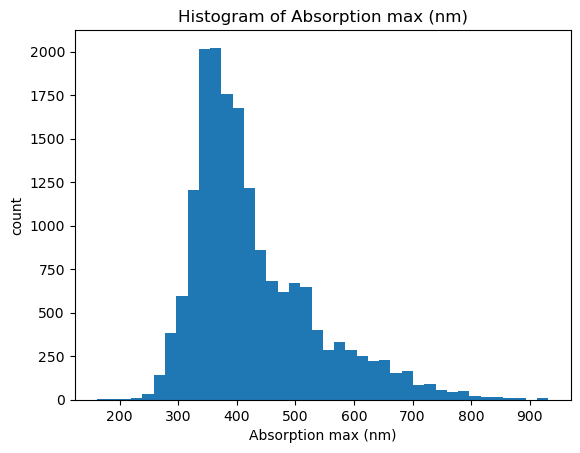

count: 17276
min / max: 162.0 931.3029316
mean / std: 427.8042026029405 105.78413795827728
quantiles: {0.01: 276.0, 0.05: 308.0, 0.5: 397.0, 0.95: 647.0, 0.99: 758.095490725}


In [4]:
# 目的変数の可視化

X = df[target_col].dropna()

plt.figure()
plt.hist(X, bins=40)
plt.title(f"Histogram of {target_col}")
plt.xlabel(f"{target_col}")
plt.ylabel("count")
plt.show()

print("count:", len(X))
print("min / max:", float(X.min()), float(X.max()))
print("mean / std:", float(X.mean()), float(X.std()))
print("quantiles:", X.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())

In [ ]:
# ============================================================
# Hold-out split: train / val / test（ランダム分割）
# ============================================================

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(
    "Hold-out split sizes ->",
    "train:", len(train_df),
    "val:", len(val_df),
    "test:", len(test_df),
)

# ============================================================
# Robust scaling（train のみで fit）: 1-task 版
# ============================================================

def fit_robust_scaler(y: pd.Series):
    y = y.astype(float)
    med = float(y.median())
    q1 = float(y.quantile(0.25))
    q3 = float(y.quantile(0.75))
    iqr = q3 - q1
    if iqr == 0:
        iqr = 1.0
    return med, iqr

def transform_robust(y, med, iqr):
    return (y.astype(float) - med) / iqr

def inverse_robust(y_scaled, med, iqr):
    return y_scaled * iqr + med

# ---- 1つだけ選んだ目的変数 ----
scaled_col = f"{target_col}_scaled"

# ---- train のみで scaler を fit ----
med, iqr = fit_robust_scaler(train_df[target_col])
scalers = {target_col: (med, iqr)}

# ---- train / val / test に同じ scaler を適用 ----
for split_df in (train_df, val_df, test_df):
    split_df[scaled_col] = transform_robust(split_df[target_col], med, iqr)

# ============================================================
# 確認ログ
# ============================================================

print(f"[fit on train] {target_col} median (raw): {med:.4f}  IQR (raw): {iqr:.4f}")
print(f"[after scaling] {scaled_col} median: {float(train_df[scaled_col].median()):.4f}")

q1 = float(train_df[scaled_col].quantile(0.25))
q3 = float(train_df[scaled_col].quantile(0.75))
print(f"[after scaling] {scaled_col} IQR: {q3 - q1:.4f}")


Hold-out split sizes -> train: 13820 val: 1728 test: 1728
[fit on train] Absorption max (nm) median (raw): 397.0000  IQR (raw): 126.0000
[after scaling] Absorption max (nm)_scaled median: 0.0000
[after scaling] Absorption max (nm)_scaled IQR: 1.0000


## SMILES→PyTorch Geometric Data変換（Dataset作成）

In [6]:
# ============================================================
# Features + SMILES -> PyG Data 変換
# （論文準拠の離散特徴量）
# ============================================================

# ----------------------------
# 原子・結合の離散特徴量設定
# ----------------------------

# 原子番号・次数の上限（クリップ用）
MAX_ATOMIC_NUM = 100
MAX_DEGREE = 5

# 結合タイプ（論文中の B 行列選択に対応）
BOND_TYPES = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}
NUM_BOND_TYPES = 4

# ----------------------------
# 追加の原子特徴量
#  - 形式電荷
#  - 混成軌道
# ----------------------------

# 形式電荷（クリップして離散化）
MIN_FC, MAX_FC = -2, 2
FC_OFFSET = -MIN_FC               # -2..2 → 0..4
NUM_FC = (MAX_FC - MIN_FC + 1)

# 混成軌道タイプ
HYB_MAP = {
    Chem.rdchem.HybridizationType.SP: 0,
    Chem.rdchem.HybridizationType.SP2: 1,
    Chem.rdchem.HybridizationType.SP3: 2,
    Chem.rdchem.HybridizationType.SP3D: 3,
    Chem.rdchem.HybridizationType.SP3D2: 4,
}
HYB_UNKNOWN = 5
NUM_HYB = 6

def atom_features(atom: Chem.rdchem.Atom) -> torch.Tensor:
    """
    原子特徴量（すべて離散値）
    x[:, :] の各列の意味：
      x[:,0]: 原子番号（クリップあり）
      x[:,1]: 原子次数（クリップあり）
      x[:,2]: 芳香族フラグ（0/1）
      x[:,3]: 形式電荷（-2..2 を 0..4 に変換）
      x[:,4]: 混成軌道タイプ
    """
    atomic_num = min(atom.GetAtomicNum(), MAX_ATOMIC_NUM)
    degree = min(atom.GetDegree(), MAX_DEGREE)
    aromatic = int(atom.GetIsAromatic())

    # 形式電荷をクリップしてオフセット
    formal_charge = atom.GetFormalCharge()
    formal_charge = max(MIN_FC, min(formal_charge, MAX_FC)) + FC_OFFSET  # 0..NUM_FC-1

    # 混成軌道（未知は HYB_UNKNOWN）
    hyb_idx = HYB_MAP.get(atom.GetHybridization(), HYB_UNKNOWN)

    return torch.tensor([atomic_num, degree, aromatic, formal_charge, hyb_idx], dtype=torch.long)

def bond_features(bond: Chem.rdchem.Bond) -> torch.Tensor:
    """
    結合特徴量（離散）
    edge_attr[:, :] の各列の意味：
      edge_attr[:,0]: 結合タイプ（SINGLE/DOUBLE/TRIPLE/AROMATIC）
      edge_attr[:,1]: 共役フラグ（0/1）
      edge_attr[:,2]: 環内結合フラグ（0/1）
    """
    bond_type = BOND_TYPES.get(bond.GetBondType(), 0)
    conjugated = int(bond.GetIsConjugated())
    in_ring = int(bond.IsInRing())
    return torch.tensor([bond_type, conjugated, in_ring], dtype=torch.long)


def smiles_to_pyg(smiles: str):
    """
    SMILES 文字列を PyG の Data に変換（yは付けない）。
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [num_nodes, 5]

    edge_index_list = []
    edge_attr_list = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list.append([i, j]); edge_attr_list.append(bf)
        edge_index_list.append([j, i]); edge_attr_list.append(bf)

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.smiles = smiles
    return data

class DyeSolventPairDataset1Task(Dataset):
    """
    1-task 回帰用 Dataset
    DataFrame（Chromophore, Solvent, target_col_scaled）から
    (dye_data, sol_data, y) を返す。

    y は shape [1] に統一（バッチで [B, 1] になる）
    """
    def __init__(self, df: pd.DataFrame, target_col: str):
        self.samples = []
        bad = 0

        scaled_col = f"{target_col}_scaled"

        for _, row in df.iterrows():
            dye_smi = str(row["Chromophore"])
            sol_smi = str(row["Solvent"])

            dye_data = smiles_to_pyg(dye_smi)
            sol_data = smiles_to_pyg(sol_smi)

            if (dye_data is None) or (sol_data is None):
                bad += 1
                continue

            # ★ 1-task：yは1要素だけ
            y = torch.tensor([row[scaled_col]], dtype=torch.float)  # shape [1]

            self.samples.append((dye_data, sol_data, y))

        print(f"Converted pairs: {len(self.samples)} / {len(df)} (invalid removed: {bad})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_dye_solvent_1task(batch):
    """
    1-task 用 collate
    返り値:
      dye_batch: PyG Batch
      sol_batch: PyG Batch
      y: [B, 1]
    """
    dye_list, sol_list, y_list = zip(*batch)
    dye_batch = Batch.from_data_list(list(dye_list))
    sol_batch = Batch.from_data_list(list(sol_list))
    y = torch.stack(list(y_list), dim=0)  # [B, 1]
    return dye_batch, sol_batch, y

train_dataset = DyeSolventPairDataset1Task(train_df, target_col)
val_dataset   = DyeSolventPairDataset1Task(val_df,   target_col)
test_dataset  = DyeSolventPairDataset1Task(test_df,  target_col)

dye0, sol0, y0 = train_dataset[0]
print(dye0)
print(sol0)
print("y:", y0, "shape:", y0.shape)   # torch.Size([1]) になるはず

Converted pairs: 13820 / 13820 (invalid removed: 0)
Converted pairs: 1728 / 1728 (invalid removed: 0)
Converted pairs: 1728 / 1728 (invalid removed: 0)
Data(x=[34, 5], edge_index=[2, 74], edge_attr=[74, 3], smiles='COc1ccc(/C=C/C2=[O+][B-](F)(F)OC(/C=C/c3ccc(OC)cc3)=C2c2ccccc2)cc1')
Data(x=[5, 5], edge_index=[2, 8], edge_attr=[8, 3], smiles='CCOCC')
y: tensor([0.7460]) shape: torch.Size([1])


## PyG DataLoader（ミニバッチ化）＋ バッチの形確認

In [7]:
# DataLoader + sanity check
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_dye_solvent_1task,  # ★ここを1task用に
    drop_last=True,  # BatchNormを使うなら推奨
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_dye_solvent_1task,  # ★
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_dye_solvent_1task,  # ★
)

# 1バッチ取り出して形確認
dye_batch, sol_batch, y = next(iter(train_loader))

print("=== Dye batch ===")
print("x:", dye_batch.x.shape)
print("edge_index:", dye_batch.edge_index.shape)
print("edge_attr:", dye_batch.edge_attr.shape)
print("batch:", dye_batch.batch.shape)
print("num_graphs:", dye_batch.num_graphs)

print("\n=== Solvent batch ===")
print("x:", sol_batch.x.shape)
print("edge_index:", sol_batch.edge_index.shape)
print("edge_attr:", sol_batch.edge_attr.shape)
print("batch:", sol_batch.batch.shape)
print("num_graphs:", sol_batch.num_graphs)

print("\n=== Target ===")
print("y:", y.shape)   # ★ 1-taskなので [B, 1] になる

# GPU に乗せる
dye_batch = dye_batch.to(device)
sol_batch = sol_batch.to(device)
y = y.to(device)
print("Moved to device OK")

=== Dye batch ===
x: torch.Size([1253, 5])
edge_index: torch.Size([2, 2854])
edge_attr: torch.Size([2854, 3])
batch: torch.Size([1253])
num_graphs: 32

=== Solvent batch ===
x: torch.Size([169, 5])
edge_index: torch.Size([2, 302])
edge_attr: torch.Size([302, 3])
batch: torch.Size([169])
num_graphs: 32

=== Target ===
y: torch.Size([32, 1])
Moved to device OK


## 2D-only MPNN（PyG）モデル定義（Embedding → MessagePassing → Pooling → 回帰）

In [8]:
class EdgeCondLinearLayer(MessagePassing):
    """
    m_{ij} = W_{bond_type} h_j
    を作ってから、GRUでノード状態を更新する層。
    """
    def __init__(self, hidden_dim: int, num_bond_types: int):
        super().__init__(aggr="add")  # 近傍メッセージを加算で集約
        self.hidden_dim = hidden_dim
        self.num_bond_types = num_bond_types

        # 結合タイプごとの重み行列 W_e: [T, H, H]
        self.W = nn.Parameter(torch.empty(num_bond_types, hidden_dim, hidden_dim))
        nn.init.xavier_uniform_(self.W)

        # GRU: input=message, hidden=old_state
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, bond_type):
        """
        x        : [N, H]  ノード表現
        edge_index: [2, E] 有向エッジ
        bond_type : [E]    エッジごとの結合タイプ（0..T-1）
        """
        # propagate() は message() を呼び、aggr="add" でノードごとに集約する
        m = self.propagate(edge_index, x=x, bond_type=bond_type)  # [N, H]

        # GRUで更新（input=m, hx=x）
        x_out = self.gru(m, x)  # [N, H]
        return x_out

    def message(self, x_j, bond_type):
        """
        x_j      : [E, H]  エッジの送信元ノード表現（j側）
        bond_type: [E]     結合タイプ
        """
        bt = bond_type.to(torch.long).clamp(0, self.num_bond_types - 1)  # 安全のため範囲に収める

        # エッジごとに W_{bt} を選ぶ → [E, H, H]
        W_bt = self.W[bt]

        # m_ij = W_{bt} @ h_j
        m = torch.bmm(W_bt, x_j.unsqueeze(-1)).squeeze(-1)  # [E, H]
        return m

class MPNNEncoder(nn.Module):
    """
    分子グラフ -> 1024-d fingerprint を出すエンコーダ
    """
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        dropout: float = 0.0,
        fp_dim: int = 1024,
    ):
        super().__init__()

        # ノード特徴の埋め込み
        self.emb_atomic = nn.Embedding(MAX_ATOMIC_NUM + 1, 64)
        self.emb_degree = nn.Embedding(MAX_DEGREE + 1, 16)
        self.emb_aroma  = nn.Embedding(2, 8)
        self.emb_fc     = nn.Embedding(NUM_FC, 8)
        self.emb_hyb    = nn.Embedding(NUM_HYB, 8)

        node_in_dim = 64 + 16 + 8 + 8 + 8  # 104
        self.node_proj = nn.Linear(node_in_dim, hidden_dim)

        self.layers = nn.ModuleList([
            EdgeCondLinearLayer(hidden_dim=hidden_dim, num_bond_types=NUM_BOND_TYPES)
            for _ in range(num_layers)
        ])

        self.fp_dim = fp_dim
        self.node_to_fp = nn.Linear(hidden_dim, self.fp_dim)
        self.dropout = dropout

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr  = data.edge_attr
        batch      = data.batch

        atomic_num    = x[:, 0].clamp(0, MAX_ATOMIC_NUM)
        degree        = x[:, 1].clamp(0, MAX_DEGREE)
        aromatic      = x[:, 2].clamp(0, 1)
        formal_charge = x[:, 3].clamp(0, NUM_FC - 1)
        hybridization = x[:, 4].clamp(0, NUM_HYB - 1)

        h = torch.cat([
            self.emb_atomic(atomic_num),
            self.emb_degree(degree),
            self.emb_aroma(aromatic),
            self.emb_fc(formal_charge),
            self.emb_hyb(hybridization),
        ], dim=-1)  # [N, 104]

        h = self.node_proj(h)  # [N, hidden_dim]

        bond_type = edge_attr[:, 0].clamp(0, NUM_BOND_TYPES - 1)  # [E]

        for layer in self.layers:
            h = layer(h, edge_index, bond_type)

        h_fp = self.node_to_fp(h)              # [N, fp_dim]
        g    = global_add_pool(h_fp, batch)    # [B, fp_dim], Lossが暴れるなら、global_mean_pool に変更

        if self.dropout > 0:
            g = F.dropout(g, p=self.dropout, training=self.training)

        return g  # [B, fp_dim]

class DyeSolventMPNNRegressor(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        fp_dim: int = 1024,
        num_targets=1,  # ★1-task
        dropout: float = 0.0,
        share_encoder: bool = False,  # Trueなら色素と溶媒で重み共有
    ):
        super().__init__()

        enc = MPNNEncoder(hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, fp_dim=fp_dim)
        if share_encoder:
            self.dye_encoder = enc
            self.sol_encoder = enc
        else:
            self.dye_encoder = enc
            self.sol_encoder = MPNNEncoder(hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, fp_dim=fp_dim)

        in_dim = fp_dim * 2
        self.fc1 = nn.Linear(in_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.out = nn.Linear(256, num_targets)
        self.dropout = dropout

    def forward(self, dye_batch, sol_batch):
        h_dye = self.dye_encoder(dye_batch)  # [B, fp_dim]
        h_sol = self.sol_encoder(sol_batch)  # [B, fp_dim]

        h = torch.cat([h_dye, h_sol], dim=1)  # [B, 2*fp_dim]

        z = F.relu(self.bn1(self.fc1(h)))
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn2(self.fc2(z)))
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        return self.out(z)  # [B, num_targets]

In [9]:
# sanity check（1-task）
model = DyeSolventMPNNRegressor(num_targets=1).to(device)

dye_batch, sol_batch, y = next(iter(train_loader))
dye_batch = dye_batch.to(device)
sol_batch = sol_batch.to(device)
y = y.to(device)

pred = model(dye_batch, sol_batch)

print("pred.shape:", pred.shape)  # [B, 1]
print("y.shape:", y.shape)        # [B, 1]
print("pred[:5]:", pred[:5].detach().cpu().squeeze(-1))
print("y[:5]:", y[:5].detach().cpu().squeeze(-1))

pred.shape: torch.Size([32, 1])
y.shape: torch.Size([32, 1])
pred[:5]: tensor([ 0.5077, -0.8624, -0.2220,  0.3295, -0.1152])
y[:5]: tensor([ 0.1984, -0.5238, -0.1270, -0.4921, -0.5794])


## 学習・評価

In [10]:
# --- 損失関数 ---
criterion = nn.MSELoss()

# --- 最適化手法 ---
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# --- 学習率スケジューラ ---
# 論文の「エポックごとに 2×10^-6 の減衰」を
# 指数減衰として解釈し、epoch ごとに lr を少しずつ下げる
#   lr_{t+1} = lr_t * (1 - 2e-6)
decay = 2e-6
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (1.0 - decay) ** epoch
)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    n = 0

    for dye_batch, sol_batch, y in tqdm(loader, desc="train", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()  # ★ 1-task: [B, 1]

        optimizer.zero_grad()

        pred = model(dye_batch, sol_batch)  # ★ 1-task: [B, 1]
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            mae = torch.mean(torch.abs(pred - y))

        bsz = y.size(0)
        total_loss += loss.item() * bsz
        total_mae  += mae.item()  * bsz
        n += bsz

    return total_loss / n, total_mae / n

@torch.no_grad()
def evaluate_scaled_1task(model, loader, device, target_col: str):
    """
    scaled 空間での 1-task 評価
    Returns:
      {target_col: {mae, rmse, r2}}
    """
    model.eval()
    preds, ys = [], []

    for dye_batch, sol_batch, y in tqdm(loader, desc="eval_scaled", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)

        pred = model(dye_batch, sol_batch).cpu()  # [B, 1]
        y = y.cpu()                                # [B, 1]
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0).squeeze(1)  # [N]
    ys    = torch.cat(ys, dim=0).squeeze(1)     # [N]

    resid = preds - ys
    mae = resid.abs().mean().item()
    rmse = torch.sqrt((resid ** 2).mean()).item()

    y_mean = ys.mean()
    ss_tot = torch.sum((ys - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return {target_col: {"mae": mae, "rmse": rmse, "r2": r2}}

@torch.no_grad()
def evaluate_raw_1task(model, loader, device, target_col: str, scaler):
    """
    raw 空間（nm/ns）での 1-task 評価
    scaler: (med, iqr)
    Returns:
      {target_col: {mae, rmse, r2}}
    """
    med, iqr = scaler

    model.eval()
    preds, ys = [], []

    for dye_batch, sol_batch, y in tqdm(loader, desc="eval_raw", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)

        pred = model(dye_batch, sol_batch).cpu().squeeze(1)  # [B]
        y = y.cpu().squeeze(1)                               # [B]
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)  # scaled [N]
    ys    = torch.cat(ys, dim=0)     # scaled [N]

    pred_raw = preds * float(iqr) + float(med)
    y_raw    = ys    * float(iqr) + float(med)

    resid = pred_raw - y_raw
    mae = resid.abs().mean().item()
    rmse = torch.sqrt((resid ** 2).mean()).item()

    y_mean = y_raw.mean()
    ss_tot = torch.sum((y_raw - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return {target_col: {"mae": mae, "rmse": rmse, "r2": r2}}

def results_to_df(results: dict, title: str):
    """
    評価結果を DataFrame にまとめて表示
    """
    dfm = pd.DataFrame(results).T
    dfm.index.name = "target"
    dfm = dfm[["mae", "rmse", "r2"]]
    print(f"\n[{title}]")
    print(dfm)
    return dfm

In [11]:
# 学習条件
max_epochs = 500
patience = 20

monitor_key = "rmse"  # "rmse" or "mae"

best_metric = float("inf")
best_state = None
bad_epochs = 0
history = []

for epoch in range(1, max_epochs + 1):

    # 1) Train
    train_mse, train_mae = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # 2) Validation (scaled)
    val_scaled = evaluate_scaled_1task(
        model, val_loader, device, target_col
    )
    current = val_scaled[target_col][monitor_key]

    # 3) LR scheduler
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # 4) ログ
    v = val_scaled[target_col]
    print(
        f"[Epoch {epoch:03d}] lr={lr:.2e} "
        f"train_MSE={train_mse:.4f} train_MAE={train_mae:.4f} | "
        f"VAL {target_col}: RMSE={v['rmse']:.4f} MAE={v['mae']:.4f} R2={v['r2']:.4f}"
    )

    # ログ保存（1-task）
    history.append({
        "epoch": epoch,
        "lr": lr,
        "train_mse": train_mse,
        "train_mae": train_mae,
        "val_rmse": v["rmse"],
        "val_mae":  v["mae"],
        "val_r2":   v["r2"],
    })

    # 5) Early stopping
    if current < best_metric - 1e-6:
        best_metric = current
        best_state = copy.deepcopy(model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(
                f"Early stopping triggered (patience={patience}). "
                f"Best VAL {target_col}_{monitor_key}={best_metric:.4f}"
            )
            break

# ============================================================
# 最良モデルを復元、最終評価
# ============================================================

if best_state is not None:
    model.load_state_dict(best_state)

model.to(device).eval()

val_scaled_best = evaluate_scaled_1task(model, val_loader, device, target_col)
print("\n===== BEST MODEL: VAL (scaled) =====")
print(f"monitor: {target_col}_{monitor_key} = {val_scaled_best[target_col][monitor_key]:.4f}")

# --- Test (scaled) ---
test_scaled = evaluate_scaled_1task(model, test_loader, device, target_col)

# --- Test (raw) ---
# ここは scaler の持ち方で分岐：
# 1-task 版で scaler=(med,iqr) としているなら scaler を渡す
test_raw = evaluate_raw_1task(model, test_loader, device, target_col, scalers[target_col])

print("\n===== FINAL TEST (scaled space) =====")
print(target_col, test_scaled[target_col])

print("\n===== FINAL TEST (raw space) =====")
print(target_col, test_raw[target_col])

test_scaled_df = results_to_df(test_scaled, "TEST scaled metrics")
test_raw_df    = results_to_df(test_raw,    "TEST raw metrics")


[Epoch 001] lr=1.00e-03 train_MSE=0.3652 train_MAE=0.4342 | VAL Absorption max (nm): RMSE=0.4539 MAE=0.3348 R2=0.6946


[Epoch 002] lr=1.00e-03 train_MSE=0.2115 train_MAE=0.3324 | VAL Absorption max (nm): RMSE=0.4618 MAE=0.3283 R2=0.6839


[Epoch 003] lr=1.00e-03 train_MSE=0.1607 train_MAE=0.2897 | VAL Absorption max (nm): RMSE=0.3919 MAE=0.2764 R2=0.7723


[Epoch 004] lr=1.00e-03 train_MSE=0.1482 train_MAE=0.2795 | VAL Absorption max (nm): RMSE=0.3414 MAE=0.2472 R2=0.8272


[Epoch 005] lr=1.00e-03 train_MSE=0.1260 train_MAE=0.2570 | VAL Absorption max (nm): RMSE=0.3557 MAE=0.2469 R2=0.8125


[Epoch 006] lr=1.00e-03 train_MSE=0.1219 train_MAE=0.2541 | VAL Absorption max (nm): RMSE=0.2828 MAE=0.1978 R2=0.8814


[Epoch 007] lr=1.00e-03 train_MSE=0.1090 train_MAE=0.2423 | VAL Absorption max (nm): RMSE=0.2919 MAE=0.2129 R2=0.8737


[Epoch 008] lr=1.00e-03 train_MSE=0.1026 train_MAE=0.2349 | VAL Absorption max (nm): RMSE=0.3539 MAE=0.2596 R2=0.8143


[Epoch 009] lr=1.00e-03 train_MSE=0.0963 train_MAE=0.2267 | VAL Absorption max (nm): RMSE=0.2741 MAE=0.1950 R2=0.8886


[Epoch 010] lr=1.00e-03 train_MSE=0.0889 train_MAE=0.2188 | VAL Absorption max (nm): RMSE=0.3051 MAE=0.2303 R2=0.8620


[Epoch 011] lr=1.00e-03 train_MSE=0.0903 train_MAE=0.2213 | VAL Absorption max (nm): RMSE=0.3104 MAE=0.2280 R2=0.8572


[Epoch 012] lr=1.00e-03 train_MSE=0.1027 train_MAE=0.2336 | VAL Absorption max (nm): RMSE=0.3536 MAE=0.2610 R2=0.8146


[Epoch 013] lr=1.00e-03 train_MSE=0.0981 train_MAE=0.2299 | VAL Absorption max (nm): RMSE=0.3039 MAE=0.2221 R2=0.8631


[Epoch 014] lr=1.00e-03 train_MSE=0.0822 train_MAE=0.2102 | VAL Absorption max (nm): RMSE=0.2877 MAE=0.2058 R2=0.8773


[Epoch 015] lr=1.00e-03 train_MSE=0.0815 train_MAE=0.2114 | VAL Absorption max (nm): RMSE=0.2613 MAE=0.1867 R2=0.8988


[Epoch 016] lr=1.00e-03 train_MSE=0.0772 train_MAE=0.2046 | VAL Absorption max (nm): RMSE=0.2597 MAE=0.1815 R2=0.9000


[Epoch 017] lr=1.00e-03 train_MSE=0.0786 train_MAE=0.2061 | VAL Absorption max (nm): RMSE=0.2718 MAE=0.2011 R2=0.8905


[Epoch 018] lr=1.00e-03 train_MSE=0.0784 train_MAE=0.2059 | VAL Absorption max (nm): RMSE=0.2693 MAE=0.1886 R2=0.8925


[Epoch 019] lr=1.00e-03 train_MSE=0.0769 train_MAE=0.2049 | VAL Absorption max (nm): RMSE=0.2590 MAE=0.1812 R2=0.9005


[Epoch 020] lr=1.00e-03 train_MSE=0.0769 train_MAE=0.2057 | VAL Absorption max (nm): RMSE=0.2894 MAE=0.2022 R2=0.8759


[Epoch 021] lr=1.00e-03 train_MSE=0.0846 train_MAE=0.2135 | VAL Absorption max (nm): RMSE=0.3367 MAE=0.2481 R2=0.8320


[Epoch 022] lr=1.00e-03 train_MSE=0.0789 train_MAE=0.2088 | VAL Absorption max (nm): RMSE=0.2595 MAE=0.1878 R2=0.9002


[Epoch 023] lr=1.00e-03 train_MSE=0.0717 train_MAE=0.1994 | VAL Absorption max (nm): RMSE=0.2601 MAE=0.1897 R2=0.8997


[Epoch 024] lr=1.00e-03 train_MSE=0.0718 train_MAE=0.1998 | VAL Absorption max (nm): RMSE=0.2545 MAE=0.1885 R2=0.9040


[Epoch 025] lr=1.00e-03 train_MSE=0.0659 train_MAE=0.1913 | VAL Absorption max (nm): RMSE=0.2417 MAE=0.1753 R2=0.9134


[Epoch 026] lr=1.00e-03 train_MSE=0.0705 train_MAE=0.1962 | VAL Absorption max (nm): RMSE=0.2782 MAE=0.1983 R2=0.8853


[Epoch 027] lr=1.00e-03 train_MSE=0.0708 train_MAE=0.1969 | VAL Absorption max (nm): RMSE=0.2694 MAE=0.1894 R2=0.8925


[Epoch 028] lr=1.00e-03 train_MSE=0.0847 train_MAE=0.2143 | VAL Absorption max (nm): RMSE=0.2674 MAE=0.1939 R2=0.8940


[Epoch 029] lr=1.00e-03 train_MSE=0.0754 train_MAE=0.2014 | VAL Absorption max (nm): RMSE=0.2799 MAE=0.2020 R2=0.8838


[Epoch 030] lr=1.00e-03 train_MSE=0.0697 train_MAE=0.1964 | VAL Absorption max (nm): RMSE=0.2844 MAE=0.2042 R2=0.8801


[Epoch 031] lr=1.00e-03 train_MSE=0.0618 train_MAE=0.1841 | VAL Absorption max (nm): RMSE=0.2388 MAE=0.1641 R2=0.9155


[Epoch 032] lr=1.00e-03 train_MSE=0.0655 train_MAE=0.1879 | VAL Absorption max (nm): RMSE=0.2624 MAE=0.1844 R2=0.8980


[Epoch 033] lr=1.00e-03 train_MSE=0.0702 train_MAE=0.1951 | VAL Absorption max (nm): RMSE=0.2790 MAE=0.2009 R2=0.8846


[Epoch 034] lr=1.00e-03 train_MSE=0.0680 train_MAE=0.1931 | VAL Absorption max (nm): RMSE=0.2657 MAE=0.1957 R2=0.8954


[Epoch 035] lr=1.00e-03 train_MSE=0.0707 train_MAE=0.1963 | VAL Absorption max (nm): RMSE=0.2629 MAE=0.1945 R2=0.8976


[Epoch 036] lr=1.00e-03 train_MSE=0.0677 train_MAE=0.1930 | VAL Absorption max (nm): RMSE=0.2687 MAE=0.2006 R2=0.8930


[Epoch 037] lr=1.00e-03 train_MSE=0.0671 train_MAE=0.1931 | VAL Absorption max (nm): RMSE=0.2439 MAE=0.1733 R2=0.9118


[Epoch 038] lr=1.00e-03 train_MSE=0.0645 train_MAE=0.1876 | VAL Absorption max (nm): RMSE=0.2391 MAE=0.1720 R2=0.9153


[Epoch 039] lr=1.00e-03 train_MSE=0.0606 train_MAE=0.1825 | VAL Absorption max (nm): RMSE=0.2727 MAE=0.2015 R2=0.8898


[Epoch 040] lr=1.00e-03 train_MSE=0.0696 train_MAE=0.1940 | VAL Absorption max (nm): RMSE=0.2599 MAE=0.1847 R2=0.8999


[Epoch 041] lr=1.00e-03 train_MSE=0.0763 train_MAE=0.2023 | VAL Absorption max (nm): RMSE=0.2714 MAE=0.1915 R2=0.8908


[Epoch 042] lr=1.00e-03 train_MSE=0.0738 train_MAE=0.2015 | VAL Absorption max (nm): RMSE=0.2642 MAE=0.1867 R2=0.8965


[Epoch 043] lr=1.00e-03 train_MSE=0.0700 train_MAE=0.1942 | VAL Absorption max (nm): RMSE=0.2597 MAE=0.1825 R2=0.9000


[Epoch 044] lr=1.00e-03 train_MSE=0.0619 train_MAE=0.1837 | VAL Absorption max (nm): RMSE=0.2692 MAE=0.1954 R2=0.8926


[Epoch 045] lr=1.00e-03 train_MSE=0.0660 train_MAE=0.1901 | VAL Absorption max (nm): RMSE=0.2502 MAE=0.1758 R2=0.9072


[Epoch 046] lr=1.00e-03 train_MSE=0.0689 train_MAE=0.1945 | VAL Absorption max (nm): RMSE=0.2455 MAE=0.1757 R2=0.9107


[Epoch 047] lr=1.00e-03 train_MSE=0.0647 train_MAE=0.1881 | VAL Absorption max (nm): RMSE=0.2555 MAE=0.1851 R2=0.9033


[Epoch 048] lr=1.00e-03 train_MSE=0.0611 train_MAE=0.1825 | VAL Absorption max (nm): RMSE=0.2487 MAE=0.1794 R2=0.9083


[Epoch 049] lr=1.00e-03 train_MSE=0.0602 train_MAE=0.1820 | VAL Absorption max (nm): RMSE=0.2474 MAE=0.1739 R2=0.9093


[Epoch 050] lr=1.00e-03 train_MSE=0.0645 train_MAE=0.1877 | VAL Absorption max (nm): RMSE=0.2534 MAE=0.1807 R2=0.9048


[Epoch 051] lr=1.00e-03 train_MSE=0.0654 train_MAE=0.1898 | VAL Absorption max (nm): RMSE=0.2636 MAE=0.1827 R2=0.8970
Early stopping triggered (patience=20). Best VAL Absorption max (nm)_rmse=0.2388



===== BEST MODEL: VAL (scaled) =====
monitor: Absorption max (nm)_rmse = 0.2388



===== FINAL TEST (scaled space) =====
Absorption max (nm) {'mae': 0.17163528501987457, 'rmse': 0.24708686769008636, 'r2': 0.914004921913147}

===== FINAL TEST (raw space) =====
Absorption max (nm) {'mae': 21.626047134399414, 'rmse': 31.132944107055664, 'r2': 0.914004921913147}

[TEST scaled metrics]
                          mae      rmse        r2
target                                           
Absorption max (nm)  0.171635  0.247087  0.914005

[TEST raw metrics]
                           mae       rmse        r2
target                                             
Absorption max (nm)  21.626047  31.132944  0.914005


,epoch,lr,train_mse,train_mae,val_rmse,val_mae,val_r2
0,1,0.001,0.365169,0.434173,0.453906,0.334765,0.694605
1,2,0.001,0.211466,0.332426,0.461822,0.328253,0.683860
2,3,0.001,0.160681,0.289727,0.391943,0.276449,0.772293
3,4,0.001,0.148199,0.279497,0.341434,0.247243,0.827200
4,5,0.001,0.125967,0.257014,0.355680,0.246941,0.812479


columns: ['epoch', 'lr', 'train_mse', 'train_mae', 'val_rmse', 'val_mae', 'val_r2']


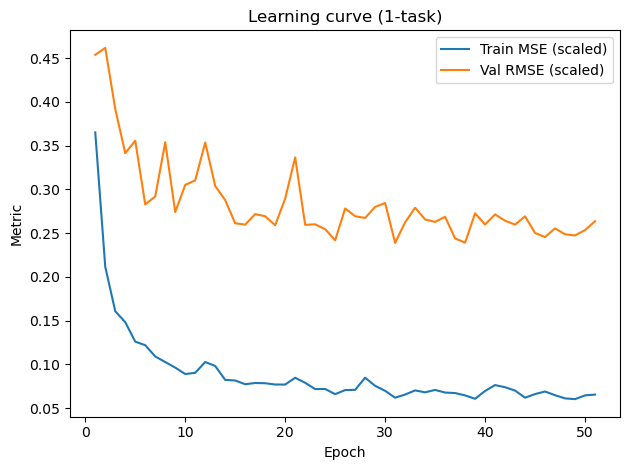

In [12]:
# history -> DataFrame
hist_df = pd.DataFrame(history)

display(hist_df.head())
print("columns:", list(hist_df.columns))

plt.figure()
plt.plot(hist_df["epoch"].tolist(), hist_df["train_mse"].tolist(), label="Train MSE (scaled)")
plt.plot(hist_df["epoch"].tolist(), hist_df["val_rmse"].tolist(),  label="Val RMSE (scaled)")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Learning curve (1-task)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# 評価・可視化用のユーティリティ関数、予測・真値・識別子をまとめて返す
@torch.no_grad()
def predict_on_loader(model, loader, device, desc=None):
    """
    Two-tower loader:
      loader yields (dye_batch, sol_batch, y)

    Returns:
      pred: [N, T]
      true: [N, T]
      dye_smiles: list[str] length N
      sol_smiles: list[str] length N
    """
    model.eval()
    all_pred, all_true = [], []
    dye_smiles_all, sol_smiles_all = [], []

    it = loader
    if desc is not None:
        it = tqdm(loader, desc=desc, leave=False)

    for dye_batch, sol_batch, y in it:
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()

        pred = model(dye_batch, sol_batch)  # [B, T]

        all_pred.append(pred.detach().cpu())
        all_true.append(y.detach().cpu())

        # PyG Batch は、各 Data の属性(smiles)を list として保持します
        if hasattr(dye_batch, "smiles"):
            dye_smiles_all.extend(list(dye_batch.smiles))
        else:
            dye_smiles_all.extend([""] * int(y.size(0)))

        if hasattr(sol_batch, "smiles"):
            sol_smiles_all.extend(list(sol_batch.smiles))
        else:
            sol_smiles_all.extend([""] * int(y.size(0)))

    pred = torch.cat(all_pred, dim=0)
    true = torch.cat(all_true, dim=0)

    n = true.shape[0]
    dye_smiles_all = dye_smiles_all[:n]
    sol_smiles_all = sol_smiles_all[:n]

    return pred, true, dye_smiles_all, sol_smiles_all

In [14]:
@torch.no_grad()
def regression_metrics_torch(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    1つのターゲットに対して回帰指標（MAE / RMSE / R^2）を計算する。

    Parameters
    ----------
    y_true : torch.Tensor, shape [N]
        正解値（CPUテンソル想定。GPUでも動くが最後に .item() するためCPU推奨）
    y_pred : torch.Tensor, shape [N]
        予測値

    Returns
    -------
    mae : float
    rmse: float
    r2  : float
    """
    # 念のため float 化（学習で float を使っていても型が混ざることがあるため）
    y_true = y_true.float()
    y_pred = y_pred.float()

    resid = y_pred - y_true

    # 平均絶対誤差（MAE）
    mae = resid.abs().mean().item()

    # 二乗平均平方根誤差（RMSE）
    rmse = torch.sqrt((resid ** 2).mean()).item()

    # 決定係数（R^2）
    # R^2 = 1 - SS_res / SS_tot
    y_mean = y_true.mean()
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2


@torch.no_grad()
def get_pred_true_1task(model, loader, device):
    """
    1-task 用：
    pred, true ともに shape [N]
    """
    model.eval()
    preds, trues = [], []

    for dye_batch, sol_batch, y in loader:
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()          # [B, 1]

        pred = model(dye_batch, sol_batch)  # [B, 1]

        preds.append(pred.squeeze(1).cpu())
        trues.append(y.squeeze(1).cpu())

    return torch.cat(preds), torch.cat(trues)

def inverse_robust_torch(y_scaled: torch.Tensor, med: float, iqr: float):
    """
    robust scaling の逆変換（scaled -> raw）を行う。

    robust scaling: y_scaled = (y - med) / iqr
    inverse       : y = y_scaled * iqr + med
    """
    return y_scaled * float(iqr) + float(med)


def plot_parity_overlay_1task(
    y_true_train, y_pred_train,
    y_true_test,  y_pred_test,
    target_col, scaler, use_raw=True
):
    """
    1-task parity plot（train / test overlay）
    NumPyが使えない環境でも動くよう、matplotlibには list を渡す
    """
    # raw へ逆変換（関数に集約）
    if use_raw:
        med, iqr = scaler
        y_true_train = inverse_robust_torch(y_true_train, med, iqr)
        y_pred_train = inverse_robust_torch(y_pred_train, med, iqr)
        y_true_test  = inverse_robust_torch(y_true_test,  med, iqr)
        y_pred_test  = inverse_robust_torch(y_pred_test,  med, iqr)

    # metrics
    mae_tr, rmse_tr, r2_tr = regression_metrics_torch(y_true_train, y_pred_train)
    mae_te, rmse_te, r2_te = regression_metrics_torch(y_true_test,  y_pred_test)

    vmin = min(y_true_train.min(), y_pred_train.min(),
               y_true_test.min(),  y_pred_test.min()).item()
    vmax = max(y_true_train.max(), y_pred_train.max(),
               y_true_test.max(),  y_pred_test.max()).item()

    unit = "nm" if "nm" in target_col else ("ns" if "ns" in target_col else "")
    xlabel = f"True ({unit})" if unit else "True"
    ylabel = f"Pred ({unit})" if unit else "Pred"

    plt.figure(figsize=(5, 5))

    # Train（NumPy不可なので tolist() で渡す）
    plt.scatter(
        y_true_train.detach().cpu().tolist(),
        y_pred_train.detach().cpu().tolist(),
        s=12, alpha=0.35,
        label=f"Train  MAE={mae_tr:.2f} RMSE={rmse_tr:.2f} R²={r2_tr:.3f}"
    )

    # Test（★ここは y_true_test / y_pred_test を使う）
    plt.scatter(
        y_true_test.detach().cpu().tolist(),
        y_pred_test.detach().cpu().tolist(),
        s=18, alpha=0.65,
        label=f"Test   MAE={mae_te:.2f} RMSE={rmse_te:.2f} R²={r2_te:.3f}"
    )

    plt.plot([vmin, vmax], [vmin, vmax], "--", lw=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Parity plot – {target_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

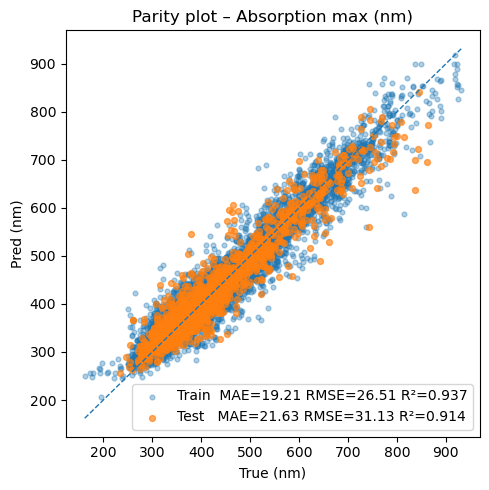

In [15]:
# train / test の予測取得

pred_tr, true_tr = get_pred_true_1task(model, train_loader, device)
pred_te, true_te = get_pred_true_1task(model, test_loader,  device)

plot_parity_overlay_1task(
    y_true_train=true_tr,
    y_pred_train=pred_tr,
    y_true_test=true_te,
    y_pred_test=pred_te,
    target_col=target_col,
    scaler=scalers[target_col],   # (med, iqr)
    use_raw=True
)


## 保存

In [16]:
def ensure_dir(path: str):
    """
    保存先ディレクトリを作成
    すでに存在していてもエラーにならない
    """
    os.makedirs(path, exist_ok=True)

def build_versions() -> Dict[str, str]:
    """
    checkpointに環境情報を残すための辞書を作る関数
    """
    return {
        "python": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
        "torch": torch.__version__,
        "torch_geometric": torch_geometric.__version__,
        "rdkit": getattr(Chem, "__version__", "unknown"),
    }

def scalers_to_serializable(scalers: Dict[str, Tuple[float, float]]) -> Dict[str, Dict[str, float]]:
    """
    robust scalerの保存
    """
    return {k: {"median": float(v[0]), "iqr": float(v[1])} for k, v in scalers.items()}

def serializable_to_scalers(d: Dict[str, Dict[str, float]]) -> Dict[str, Tuple[float, float]]:
    """
    robust scalerの復元
    """
    return {k: (float(v["median"]), float(v["iqr"])) for k, v in d.items()}

def inverse_robust_scalar(x_scaled: float, med: float, iqr: float) -> float:
    """
    推論で得たscaledの出力を元のスケールに戻す
    """
    return float(x_scaled * iqr + med)

def canonicalize_smiles(smi: str) -> Optional[str]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

def save_checkpoint_generic(
    model: torch.nn.Module,                                 # 学習済みのPyTorchモデル
    dataset_name: str,                                      # 保存先のフォルダ名
    target_cols: List[str],                                 # 出力タスク名の順序
    scalers: Dict[str, Tuple[float, float]],                # robust scaler
    save_root: str = "models",                              # ルート
    ckpt_name: str = "checkpoint.pt",                       # チェックポイント名
    model_name: str = "mpnn_edgecond_gru",
    preprocess_name: str = "discrete_atom_bond_v2",
    model_config: Optional[Dict[str, Any]] = None,
    preprocess_config: Optional[Dict[str, Any]] = None,
):
    """
    Save a single checkpoint + optional json sidecars.

    Folder: {save_root}/{dataset_name}/
    """
    save_dir = os.path.join(save_root, dataset_name)
    ensure_dir(save_dir)

    ckpt_path = os.path.join(save_dir, ckpt_name)

    # Build minimal model_config if not provided
    if model_config is None:
        model_config = {
            "model_name": model_name,
            "hidden_dim": int(getattr(model, "layers", None)[0].hidden_dim) if hasattr(model, "layers") else 128,
            "num_layers": int(len(model.layers)) if hasattr(model, "layers") else 3,
            "dropout": float(getattr(model, "dropout", 0.0)),
            "fp_dim": int(getattr(model, "fp_dim", 1024)),
            "num_targets": int(len(target_cols)),
            "target_cols": list(target_cols),  # ORDER IS CRITICAL
        }
    else:
        # enforce critical fields
        model_config = dict(model_config)
        model_config["model_name"] = model_name
        model_config["num_targets"] = int(len(target_cols))
        model_config["target_cols"] = list(target_cols)

    if preprocess_config is None:
        preprocess_config = {
            "preprocess_name": preprocess_name,
            "smiles_canonicalize": True,
            "rdkit_sanitize": True,
        }
    else:
        preprocess_config = dict(preprocess_config)
        preprocess_config["preprocess_name"] = preprocess_name

    payload = {
        "state_dict": model.state_dict(),
        "dataset_name": dataset_name,
        "model_config": model_config,
        "preprocess_config": preprocess_config,
        "scalers": scalers_to_serializable(scalers),
        "versions": build_versions(),
    }

    torch.save(payload, ckpt_path)

    # sidecars (human-readable)
    with open(os.path.join(save_dir, "model_config.json"), "w", encoding="utf-8") as f:
        json.dump(model_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "preprocess_config.json"), "w", encoding="utf-8") as f:
        json.dump(preprocess_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "scalers.json"), "w", encoding="utf-8") as f:
        json.dump(payload["scalers"], f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "versions.json"), "w", encoding="utf-8") as f:
        json.dump(payload["versions"], f, indent=2, ensure_ascii=False)

    print(f"Saved: {ckpt_path}")
    return ckpt_path

In [ ]:
# ---- deep4chem 用 checkpoint 保存 ----

# ターゲット名をファイル名として安全な文字列にする
def slugify_target(s: str) -> str:
    return (
        s.replace(" ", "_")
         .replace("/", "_")
         .replace("(", "")
         .replace(")", "")
         .replace("-", "_")
    )

target_slug = slugify_target(target_col)  # 例: "Emission_max_nm"

dataset_name = f"deep4chem_{target_slug.lower()}"   # 例: deep4chem_emission_max_nm

# 1-taskでも target_cols は list にする（順序のsingle source）
target_cols_1 = [target_col]

# scalers は dict 形式（推奨）
# scalers = {target_col: (med, iqr)} になっている前提
ckpt_path = save_checkpoint_generic(
    model=model,
    dataset_name=dataset_name,
    target_cols=target_cols_1,
    scalers=scalers,
    save_root="models",
    ckpt_name="checkpoint.pt",
    model_name="deep4chem_2tower_mpnn",         # ← zinc/nrel と区別
    preprocess_name="deep4chem_dye_solvent_v1", # ← 2SMILES前処理の識別子（後で registry に追加する）
    model_config={
        "hidden_dim": 128,
        "num_layers": 3,
        "fp_dim": 1024,
        "dropout": 0.0,
        "share_encoder": False,  # もし使ったなら記録
        "num_targets": 1,
    },
    preprocess_config={
        "smiles_canonicalize": True,
        "rdkit_sanitize": True,
        "input_schema": ["Chromophore", "Solvent"],  # 2塔用メタ
    }
)

print("Saved deep4chem checkpoint to:", ckpt_path)

Saved: models/deep4chem_absorption_max_nm/checkpoint.pt
Saved deep4chem checkpoint to: models/deep4chem_absorption_max_nm/checkpoint.pt
